# Simple L-System for Space Engineers

Uses the PCGSEPy library included in this repository.

**NOTE**: Have the game *running*; leaving the game simply paused breaks the API (no calls are accepted). *Suggestion*: Use windowed mode, press `Start` after the scenario is loaded and return to this notebook.

Import required packages

In [1]:
from enum import Enum, auto
from typing import Any, Callable, Dict, List

import numpy as np


from pcgsepy.common.api_call import GameMode, get_base_values, toggle_gamemode
from pcgsepy.structure import *

## Simple L-system

A simple L-system to generate a structure using rules.

Strings used as high-level structure:
- `cockpit`
- `engine`
- `corridor`
- `thruster`
- etc...

Strings used to define blocks:
- *See `block_definitions.json` for a full list*.

Strings used to define rotation commands:
- `rotXcwY`: Clockwise rotation from X to Y
- `rotXcwZ`: Clockwise rotation from X to Z
- `rotYcwX`: Clockwise rotation from Y to X 
- `rotYcwZ`: Clockwise rotation from Y to Z 
- `rotZcwX`: Clockwise rotation from Z to X 
- `rotZcwY`: Clockwise rotation from Z to Y 
- `rotXccwY`: Counter-clockwise rotation from X to Y 
- `rotXccwZ`: Counter-clockwise rotation from X to Z  
- `rotYccwX`: Counter-clockwise rotation from Y to X  
- `rotYccwZ`: Counter-clockwise rotation from Y to Z  
- `rotZccwX`: Counter-clockwise rotation from Z to X  
- `rotZccwY`: Counter-clockwise rotation from Z to Y   

Characters used as actions:
- `[` and `]`]: Push and pop current coordinate
- `+`: Move forward along `x`
- `-`: Move backward along `x`
- `!`: Move forward along `y`
- `?`: Move backward along `y`
- `>`: Move forward along `z`
- `<`: Move backward along `z`

### L Parser class.

Expansion and production methods transform the initial axiom using the provided rules for a number `n` of iterations.

**NOTE**: Rules can have multiple characters in the *RHS*, which allows for more complex axioms. Rules are stochastic (i.e.: $LHS \rightarrow p(RHS | LHS)$); to make a rule deterministic simply use a single $LHS \rightarrow RHS$ with $p=1.$.

In [2]:
from pcgsepy.lsystem.parser import LParser
from pcgsepy.lsystem.rules import StochasticRules, RuleMaker

### Maps

Mapping axiom atoms to `Structure` interactions:

In [3]:
from pcgsepy.lsystem.actions import *

# atoms_alphabet = {
#     "+": {"action": AtomAction.MOVE, "args": Orientation.RIGHT},
#     "-": {"action": AtomAction.MOVE, "args": Orientation.LEFT},
#     "!": {"action": AtomAction.MOVE, "args": Orientation.UP},
#     "?": {"action": AtomAction.MOVE, "args": Orientation.DOWN},
#     ">": {"action": AtomAction.MOVE, "args": Orientation.FORWARD},
#     "<": {"action": AtomAction.MOVE, "args": Orientation.BACKWARD},
#     "RotXcwY": {"action": AtomAction.ROTATE, "args": Rotations.XcwY},
#     "RotXcwZ": {"action": AtomAction.ROTATE, "args": Rotations.XcwZ},
#     "RotYcwX": {"action": AtomAction.ROTATE, "args": Rotations.YcwX},
#     "RotYcwZ": {"action": AtomAction.ROTATE, "args": Rotations.YcwZ},
#     "RotZcwX": {"action": AtomAction.ROTATE, "args": Rotations.ZcwX},
#     "RotZcwY": {"action": AtomAction.ROTATE, "args": Rotations.ZcwY},
#     "RotXccwY": {"action": AtomAction.ROTATE, "args": Rotations.XccwY},
#     "RotXccwZ": {"action": AtomAction.ROTATE, "args": Rotations.XccwZ},
#     "RotYccwX": {"action": AtomAction.ROTATE, "args": Rotations.YccwX},
#     "RotYccwZ": {"action": AtomAction.ROTATE, "args": Rotations.YccwZ},
#     "RotZccwX": {"action": AtomAction.ROTATE, "args": Rotations.ZccwX},
#     "RotZccwY": {"action": AtomAction.ROTATE, "args": Rotations.ZccwY},
#     "[": {"action": AtomAction.PUSH, "args": []},
#     "]": {"action": AtomAction.POP, "args": []},
#     "cockpit": {"action": AtomAction.PLACE, "args": []},
#     "corridor": {"action": AtomAction.PLACE, "args": []},
#     "thruster": {"action": AtomAction.PLACE, "args": []},
# }

with open("./block_definitions.json", "r") as f:
    block_definitions = json.load(f)
    for k in block_definitions.keys():
        if k != "":
            atoms_alphabet[k] = {"action": AtomAction.PLACE, "args": [k]}

# orientations_ids = {
#     "U": Orientation.UP,
#     "D": Orientation.DOWN,
#     "L": Orientation.LEFT,
#     "R": Orientation.RIGHT,
#     "F": Orientation.FORWARD,
#     "B": Orientation.BACKWARD,
# }

In [4]:
# # Note: This can definitely be simplified, but for now it *works*
# _rotate_orientations = {
#     Orientation.UP: {
#         Rotations.XcwY: Orientation.RIGHT,
#         Rotations.XccwY: Orientation.LEFT,
#         Rotations.XcwZ: Orientation.UP,
#         Rotations.XccwZ: Orientation.UP,
#         Rotations.YcwX: Orientation.RIGHT,
#         Rotations.YccwX: Orientation.LEFT,
#         Rotations.YcwZ: Orientation.BACKWARD,
#         Rotations.YccwZ: Orientation.FORWARD,
#         Rotations.ZcwX: Orientation.UP,
#         Rotations.ZccwX: Orientation.UP,
#         Rotations.ZcwY: Orientation.BACKWARD,
#         Rotations.ZccwY: Orientation.FORWARD,
#     },
#     Orientation.DOWN: {
#         Rotations.XcwY: Orientation.LEFT,
#         Rotations.XccwY: Orientation.RIGHT,
#         Rotations.XcwZ: Orientation.DOWN,
#         Rotations.XccwZ: Orientation.DOWN,
#         Rotations.YcwX: Orientation.LEFT,
#         Rotations.YccwX: Orientation.RIGHT,
#         Rotations.YcwZ: Orientation.FORWARD,
#         Rotations.YccwZ: Orientation.BACKWARD,
#         Rotations.ZcwX: Orientation.DOWN,
#         Rotations.ZccwX: Orientation.DOWN,
#         Rotations.ZcwY: Orientation.FORWARD,
#         Rotations.ZccwY: Orientation.BACKWARD,
#     },
#     Orientation.LEFT: {
#         Rotations.XcwY: Orientation.UP,
#         Rotations.XccwY: Orientation.DOWN,
#         Rotations.XcwZ: Orientation.BACKWARD,
#         Rotations.XccwZ: Orientation.FORWARD,
#         Rotations.YcwX: Orientation.UP,
#         Rotations.YccwX: Orientation.DOWN,
#         Rotations.YcwZ: Orientation.LEFT,
#         Rotations.YccwZ: Orientation.LEFT,
#         Rotations.ZcwX: Orientation.FORWARD,
#         Rotations.ZccwX: Orientation.BACKWARD,
#         Rotations.ZcwY: Orientation.LEFT,
#         Rotations.ZccwY: Orientation.LEFT,
#     },
#     Orientation.RIGHT: {
#         Rotations.XcwY: Orientation.DOWN,
#         Rotations.XccwY: Orientation.UP,
#         Rotations.XcwZ: Orientation.FORWARD,
#         Rotations.XccwZ: Orientation.BACKWARD,
#         Rotations.YcwX: Orientation.DOWN,
#         Rotations.YccwX: Orientation.UP,
#         Rotations.YcwZ: Orientation.RIGHT,
#         Rotations.YccwZ: Orientation.RIGHT,
#         Rotations.ZcwX: Orientation.BACKWARD,
#         Rotations.ZccwX: Orientation.FORWARD,
#         Rotations.ZcwY: Orientation.RIGHT,
#         Rotations.ZccwY: Orientation.RIGHT,
#     },
#     Orientation.FORWARD: {
#         Rotations.XcwY: Orientation.FORWARD,
#         Rotations.XccwY: Orientation.FORWARD,
#         Rotations.XcwZ: Orientation.RIGHT,
#         Rotations.XccwZ: Orientation.LEFT,
#         Rotations.YcwX: Orientation.FORWARD,
#         Rotations.YccwX: Orientation.FORWARD,
#         Rotations.YcwZ: Orientation.DOWN,
#         Rotations.YccwZ: Orientation.UP,
#         Rotations.ZcwX: Orientation.RIGHT,
#         Rotations.ZccwX: Orientation.LEFT,
#         Rotations.ZcwY: Orientation.UP,
#         Rotations.ZccwY: Orientation.DOWN,
#     },
#     Orientation.BACKWARD: {
#         Rotations.XcwY: Orientation.BACKWARD,
#         Rotations.XccwY: Orientation.BACKWARD,
#         Rotations.XcwZ: Orientation.LEFT,
#         Rotations.XccwZ: Orientation.RIGHT,
#         Rotations.YcwX: Orientation.BACKWARD,
#         Rotations.YccwX: Orientation.BACKWARD,
#         Rotations.YcwZ: Orientation.UP,
#         Rotations.YccwZ: Orientation.DOWN,
#         Rotations.ZcwX: Orientation.LEFT,
#         Rotations.ZccwX: Orientation.RIGHT,
#         Rotations.ZcwY: Orientation.DOWN,
#         Rotations.ZccwY: Orientation.UP,
#     },
# }


# def rotate_orientation(o: Orientation, rs: List[Rotations]) -> Orientation:
#     for r in rs:
#         o = _rotate_orientations[o][r]
#     return o

### Constraint handler

In [5]:
from pcgsepy.lsystem.constraints import *

In [6]:
from pcgsepy.lsystem.constraints_funcs import *

### Solver class

The `Solver` can both solve for a given axiom and fill a `Structure` with an axiom.

In [7]:
from pcgsepy.lsystem.solver import LSolver

### Rule maker

Read a configuration file with the rules and create the Rule object.

## L-System

Populate different structures with L-system solutions at different iterations.

In [8]:
from pcgsepy.lsystem.lsystem import LSystem

### HL SOLVER ###
Expansion n.1/4; current number of axioms: 1
Expansion n.2/4; current number of axioms: 1
Expansion n.3/4; current number of axioms: 1
Expansion n.4/4; current number of axioms: 2
--- AXIOM ---
 cockpit>>>>>corridor>>>>>corridor>>>>>corridor>>>>>corridor>>>>>corridor>>>>>corridor>>>>>?????RotZcwY[corridor>>>>>thruster]!!!!!
--- FINAL CONSTRAINTS CHECK---
Constraint required_components (HARD_CONSTRAINT) at END:	True
--- AXIOM ---
 cockpit>>>>>corridor>>>>>-----RotZcwX[corridor>>>>>]+++++corridor>>>>>?????RotZcwY[corridor>>>>>]!!!!!corridor>>>>>corridor>>>>>corridor>>>>>?????RotZcwY[corridor>>>>>]!!!!!
--- FINAL CONSTRAINTS CHECK---
Constraint required_components (HARD_CONSTRAINT) at END:	False
--- AXIOM ---
 cockpit>>>>>corridor>>>>>corridor>>>>>corridor>>>>>?????RotZcwY[corridor>>>>>]!!!!!corridor>>>>>?????RotZcwY[corridor>>>>>]!!!!!?????RotZcwY[corridor>>>>>thruster]!!!!!
--- FINAL CONSTRAINTS CHECK---
Constraint required_components (HARD_CONSTRAINT) at END:	True
---

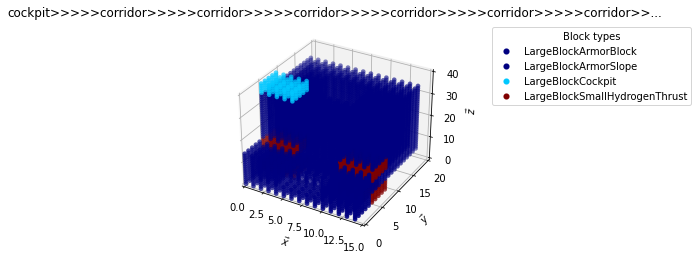

In [10]:
lsystem = LSystem(hl_rules="hlrules", ll_rules="llrules", alphabet=atoms_alphabet)

lsystem.add_hl_constraint(
    c=ConstraintHandler(
        name="required_components",
        level=ConstraintLevel.HARD_CONSTRAINT,
        when=ConstraintTime.END,
        f=components_constraint,
    )
)

# lsystem.add_hl_constraint(
#     c=ConstraintHandler(
#         name="no_intersections",
#         level=ConstraintLevel.HARD_CONSTRAINT,
#         when=ConstraintTime.DURING,
#         f=intersection_constraint,
#     )
# )

structure = lsystem.apply_rules(
    starting_axiom="begin",
    structure_dims=(100, 100, 100),
    iterations=4,
    make_graph=True,
)

### Game interaction

Place structure in-game by updating its position and rotation according to the player.

In [ ]:
if False:
    base_position, orientation_forward, orientation_up = get_base_values()
    # orientation_forward = Orientation.FORWARD
    # orientation_up = Orientation.UP
    structure.update(
        origin=base_position,
        orientation_forward=orientation_forward,
        orientation_up=orientation_up,
    )
    toggle_gamemode(GameMode.PLACING)
    place_blocks(structure.get_all_blocks(), False)
    toggle_gamemode(GameMode.EVALUATING)

In [ ]:
# jsons = [
#         generate_json(method="Observer.ObserveBlocks")
#         ]
# call_api(jsons=jsons)